# Differential Voltage Analysis for Full-Cell Battery Data

This notebook implements a flexible and modular pipeline for analyzing full-cell cycling data  
through **differential voltage analysis** (`dV/dQ`) and **differential capacity analysis** (`dQ/dV`).

---

## Workflow Overview

- **Load raw cycling data** from `.xlsx` or `.csv` formats (voltage, current, charge capacity vs. time)
- **Segment and smooth** charge/discharge curves using cubic interpolation and Savitzky–Golay filtering
- **Compute and plot** `dV/dQ` vs. capacity and `dQ/dV` vs. voltage from both raw and processed inputs
- **Combine both views** into a unified voltage-based plot with dual y-axes for side-by-side comparison

This pipeline is designed for exploratory and comparative analysis of full-cell voltage signatures,  
and can be used to study features related to battery degradation, phase transitions, and SoH trends.

## Test Dataset

This notebook uses a simplified test segment extracted from:

`1-A123 Aging Tests_Data Summary.xlsx` → Sheet: `1C Discharge`  
- Selected only the **95K case** at **0 km**  
- Used the corresponding `Charge (Ah)` and `Voltage (V)` columns

Converted to: `Data/raw_data/under_test/aging.xlsx`

The dataset comes from: [DOI: 10.5683/SP3/23MFNE](https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/23MFNE)


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import interpolate

In [2]:
current_dir = os.getcwd()
path = os.path.join(current_dir, '..', 'Data')

# Construct the file path of outputs
output_plot_path = os.path.join(current_dir, '..', 'Plots', 'dvdq_curves')
output_data_path = os.path.join(current_dir, '..', 'Data', 'processed_data')

# Make the folders if they don't exist to avoid error
os.makedirs(output_plot_path, exist_ok=True)
os.makedirs(output_data_path, exist_ok=True)

In [3]:
# Link variables to columns names used in your dataframe
I = 'Current (A)'
Q = 'Charge (Ah)'
V = 'Voltage (V)'
t = 'Time (s)'

## Smoothing

In [4]:
def smooth(df, name, window):
    
    # Apply the Savitzky-Golay filter to smooth the data
    df['Voltage_sm (V)'] = savgol_filter(df[name], window, polyorder = 1)
    
    # Return the updated DataFrame (a new column 'Voltage_sm (V)' added)
    return df
# 用polyorder=1？

## Load and Process Raw Battery Data
This section defines two key functions for preparing raw full-cell battery cycling data for analysis:  
`process_full_discharge()` and `process_full_charge()`. Both functions read raw data from an Excel or CSV file, isolate either the **discharge** or **charge** segment based on current polarity, and return a uniformly sampled, smoothed voltage–capacity dataset suitable for derivative analysis (e.g., dQ/dV, dV/dQ).

Each function performs the following steps:

- **Data Filtering**: Selects rows where current is negative (discharge) or positive (charge). If such rows are not found, the full dataset is treated as a **pseudo-discharge** or **pseudo-charge**.
- **Capacity Normalization**: Capacity is shifted to start from zero and interpolated over **1001 equally spaced points** using **cubic interpolation**.
- **Voltage Smoothing**: Applies a **Savitzky–Golay filter** to the interpolated voltage to reduce noise and prepare for derivative computation.
- **Discharge-Specific Adjustment**: For discharge, the capacity axis is reversed so that voltage decreases with decreasing capacity — aligning with the standard discharge curve visual convention.

**Functions introduced:**
- `process_full_discharge(full_file_name, window)`: Prepares discharge or pseudo-discharge voltage–capacity curves.
- `process_full_charge(full_file_name, window)`: Prepares charge voltage–capacity curves.

The output from each function is a DataFrame with columns:
- `'Q'`: Normalized capacity (increasing for charge, decreasing for discharge)
- `'V'`: Interpolated voltage
- `'Voltage_sm (V)'`: Smoothed voltage

These processed outputs are essential for generating meaningful dQ/dV and dV/dQ diagnostic plots in later sections.

In [5]:
# Main function to process full charge
def process_full_charge(full_file_name, window):
    # Construct full path and read data
    raw_path = os.path.join(path, 'raw_data')
    full_raw_path = os.path.join(raw_path, full_file_name)
    full = pd.read_excel(full_raw_path)
    
    # Check if the charge segment exists (current > 0)
    if (full[I] > 0).sum() == 0:
        print(f"No positive current values found in {full_file_name}. Charge filtering skipped.")
        charge_df = full.copy()  # Assume all rows are charge
    else:
        charge_df = full[full[I] > 0].copy()

    # If no valid data, return empty
    if charge_df.empty:
        print(f"No charge data found in {full_file_name}")
        return pd.DataFrame()
    
    # Normalize Q
    x = charge_df[Q] - charge_df[Q].min()
    y = charge_df[V]
 
    # Interpolation
    f = interpolate.interp1d(x, y, kind='cubic', fill_value="extrapolate")
    z = np.linspace(x.min(), x.max(), 1001)

    df_full_charge = pd.DataFrame({
        'Q': z,
        'V': f(z)
    })

    # Smooth voltage
    df_full_charge = smooth(df_full_charge, 'V', window)

    # Return the processed DataFrame
    return df_full_charge

In [6]:
def process_full_discharge(full_file_name, window):
    # Set the full path to the Excel file
    raw_path = os.path.join(path, 'raw_data')
    full_raw_path = os.path.join(raw_path, full_file_name)
    full = pd.read_excel(full_raw_path)
    
    # Check if the discharge segment exists
    if (full[I] < 0).sum() == 0:
        print(f"No negative current values found in {full_file_name}. Treating all rows as pseudo-discharge.")
        discharge_df = full.copy()
        auto_flip = True   # So that it'll be shown as monotonic decreasing with 'plt.gca().invert_xaxis()' called when plotting
    else:
        discharge_df = full[full[I] < 0].copy()
        auto_flip = False

    # If no valid data, return empty
    if discharge_df.empty:
        print(f"No discharge data found in {full_file_name}")
        return pd.DataFrame()  # Return empty DataFrame to avoid crashing
   
    # Normalize and scale the capacity data
    x = (discharge_df[Q] - discharge_df[Q].min())
    y = discharge_df[V]
    
    # Prepare a DataFrame for the processed data only
    df_full_discharge = pd.DataFrame(columns=['V', 'Q', 'Voltage_sm (V)'], index=np.arange(1001))
    
    # Create cubic interpolation of the voltage as a function of normalized capacity
    f = interpolate.interp1d(x, y, kind='cubic', fill_value="extrapolate")
    z = np.linspace(x.min(), x.max(), 1001)
    
    # Automatically reverse Q direction so it decreases from left to right,
    # matching the typical visual convention for discharge voltage curves
    if auto_flip:
        df_full_discharge['Q'] = z.max() - z
    else:
        df_full_discharge['Q'] = x.max() - z
    
    df_full_discharge['V'] = f(z)

    # Smooth voltage data
    window = window
    df_full_discharge = smooth(df_full_discharge, 'V', window)
    
    # Return the processed DataFrame
    return df_full_discharge

### Testing

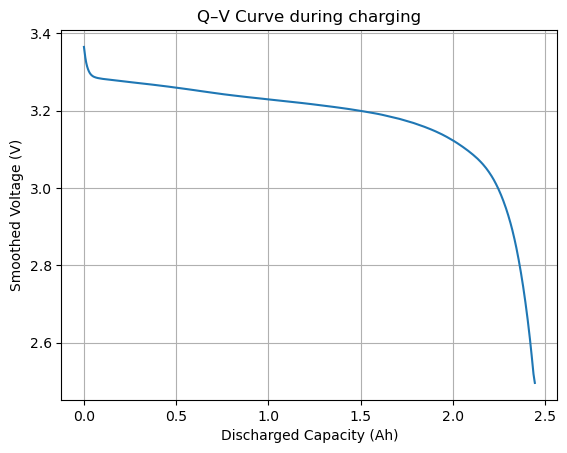

No negative current values found in under_test\aging.xlsx. Treating all rows as pseudo-discharge.


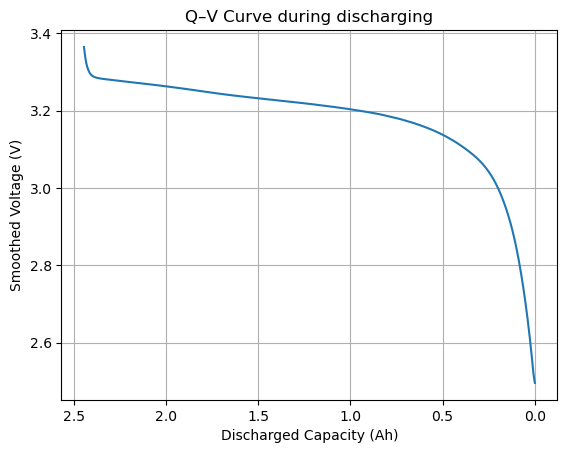

In [7]:
def plot_charge_vq(full_file_name, window):
    df = process_full_charge(full_file_name, window)
    plt.plot(df['Q'], df['Voltage_sm (V)'])
    plt.xlabel("Discharged Capacity (Ah)")
    plt.ylabel("Smoothed Voltage (V)")
    plt.title("Q–V Curve during charging")
    plt.grid(True)
    plt.show()
def plot_discharge_vq(full_file_name, window):
    df = process_full_discharge(full_file_name, window)
    plt.plot(df['Q'], df['Voltage_sm (V)'])
    plt.xlabel("Discharged Capacity (Ah)")
    plt.ylabel("Smoothed Voltage (V)")
    plt.title("Q–V Curve during discharging")
    plt.grid(True)
    plt.gca().invert_xaxis()
    plt.show()
plot_charge_vq('under_test\\aging.xlsx', 5)
plot_discharge_vq('under_test\\aging.xlsx', 5)

## dV/dQ & dQ/dV

In [8]:
def plot_dqdv(v, q, linestyle, color, label):
    dq_dv = np.divide(np.gradient(q), np.gradient(v))
    plt.plot(v, dq_dv, linestyle=linestyle, color=color, label=label)

In [9]:
def plot_dvdq(v, q, color, ax, label):
    dv_dq = np.divide(np.gradient(v), np.gradient(q))
    ax.plot(q, dv_dq, color=color, label=label)

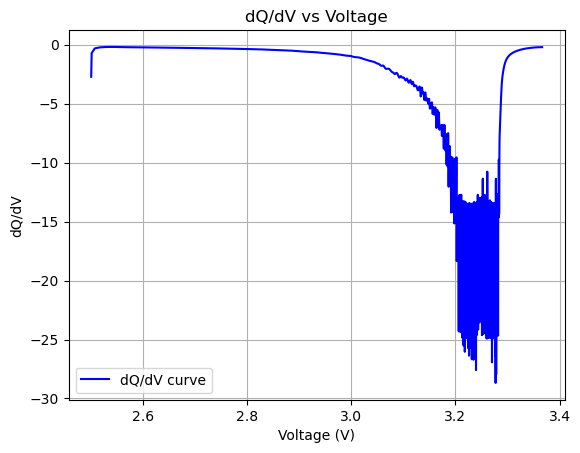

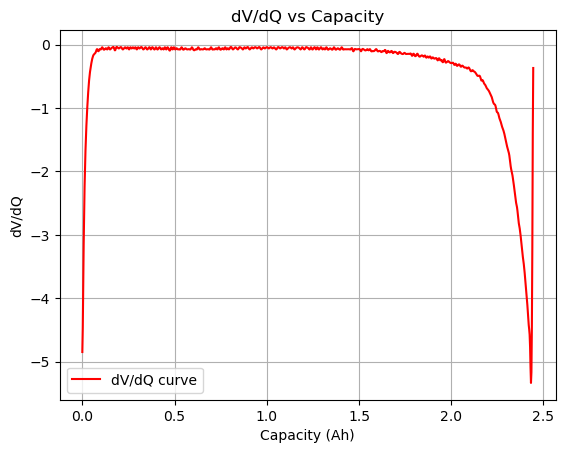

In [10]:
full_file_name = 'under_test\\aging.xlsx'
window = 5
df = process_full_charge(full_file_name, window)

fig, ax = plt.subplots()

# dQ/dV vs Voltage
plot_dqdv(df['V'], df['Q'], '-', 'blue', 'dQ/dV curve')
plt.xlabel("Voltage (V)")
plt.ylabel("dQ/dV")
plt.title("dQ/dV vs Voltage")
plt.legend()
plt.grid(True)
plt.show()

# dV/dQ vs Capacity
fig, ax = plt.subplots()
plot_dvdq(df['V'], df['Q'], 'red', ax, 'dV/dQ curve')
ax.set_xlabel("Capacity (Ah)")
ax.set_ylabel("dV/dQ")
ax.set_title("dV/dQ vs Capacity")
ax.legend()
ax.grid(True)
plt.show()

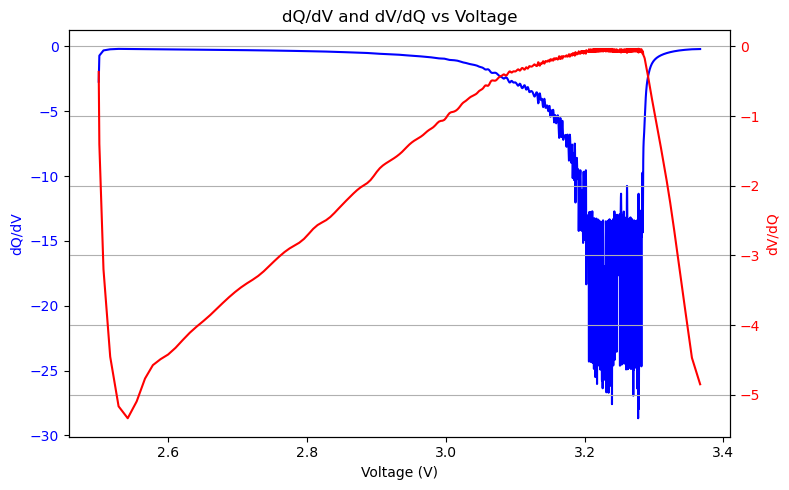

In [11]:
def plot_combined_derivatives_voltage(df):
    V = df['V']
    Q = df['Q']

    dqdv = np.divide(np.gradient(Q), np.gradient(V))
    dvdq = np.divide(np.gradient(V), np.gradient(Q))

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Left y-axis：dQ/dV
    ax1.plot(V, dqdv, color='blue', label='dQ/dV')
    ax1.set_xlabel("Voltage (V)")
    ax1.set_ylabel("dQ/dV", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Right y-axis：dV/dQ
    ax2 = ax1.twinx()
    ax2.plot(V, dvdq, color='red', label='dV/dQ')
    ax2.set_ylabel("dV/dQ", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title("dQ/dV and dV/dQ vs Voltage")
    fig.tight_layout()
    plt.grid(True)
    plt.show()
    
    
plot_combined_derivatives_voltage(df)